In [165]:
%matplotlib inline
import os
import csv
import pandas as pd
import matplotlib.pyplot as plt
import numpy
from numpy import genfromtxt
import pywt
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.grid_search import GridSearchCV
from sklearn.decomposition import PCA
from sklearn import preprocessing
from sklearn import covariance as cov
import matplotlib.pyplot as plt
import time
import xgboost as xgb
from itertools import chain, combinations
import scipy
from collections import Counter


class_names = []
images_count = 16
window = 300

# Table of Contents

* [Reading data](#Reading-data)
* [Features extraction](#Features-extraction)
* [Model](#Model)
* [Features Selection](#Feature-Selection)
* [PCA](#Feature-selection-with-PCA)
* [Demo](#Demo)
* [New person identification](#What-if-a-new-person-came?)
* [Experiments (mostly image selection)](#Experiments)
* [Gradient Boosting Classifier](#Gradient-Boosting-Classifier)

# Reading data

In [93]:
def get_list_of_files():
    files_list = [x for x in os.listdir("new_data") if x.endswith('.csv')]
    return files_list

def get_class_data_array(filename):
    my_data = genfromtxt("new_data/" + filename, delimiter=',')
    return my_data

def get_class_from_name(name):
    return class_names.index(name)

def get_initial_data_frame():
    files = get_list_of_files()
    global class_names
    class_names = files
    df = pd.concat((pd.read_csv("new_data/" + f, header = None) for f in files), ignore_index = True)
    df.columns = ['el1', 'el2', 'el3', 'el4', 'quality1', 'quality2', 'quality3', 'quality4' ,'name', 'imageID', 'imageSTEP']
    return (df)

def fix_data_mistake(data):
    data.loc[initial_df['imageID'] % 4 == 3,'imageSTEP'] -= 1
    data.loc[initial_df['imageID'] == 16, 'imageSTEP'] -= 1

In [94]:
#Read data
initial_df = get_initial_data_frame()
initial_df.head()

,el1,el2,el3,el4,quality1,quality2,quality3,quality4,name,imageID,imageSTEP
0,852.099,786.300,840.584,855.389,1,1,1,1,alexandr978307200.0,0,1
1,835.650,789.590,840.584,848.809,1,1,1,1,alexandr978307200.0,0,1
2,842.229,789.590,850.454,847.164,1,1,1,1,alexandr978307200.0,0,1
3,832.360,783.010,848.809,861.969,1,1,1,1,alexandr978307200.0,0,1
4,843.874,781.365,848.809,866.904,1,1,1,1,alexandr978307200.0,0,1


In [95]:
#Fix mistakes if needed (in place)
fix_data_mistake(initial_df)

In [96]:
#Check if mistake was fixed
initial_df[initial_df['imageID'] % 4 == 3].head()

,el1,el2,el3,el4,quality1,quality2,quality3,quality4,name,imageID,imageSTEP
1420,850.454,806.04,840.584,861.969,1,1,1,1,alexandr978307200.0,3,1
1421,842.229,806.04,845.519,857.034,1,1,1,1,alexandr978307200.0,3,1
1422,852.099,802.75,847.164,858.679,1,1,1,1,alexandr978307200.0,3,1
1423,848.809,799.46,843.874,853.744,1,1,1,1,alexandr978307200.0,3,1
1424,843.874,799.46,850.454,855.389,1,1,1,1,alexandr978307200.0,3,1


In [97]:
initial_df[initial_df['imageID'] == 16].head()

,el1,el2,el3,el4,quality1,quality2,quality3,quality4,name,imageID,imageSTEP
30280,863.614,804.395,801.105,861.969,1,1,2,1,alexandr978307200.0,16,4
30281,866.904,819.200,590.547,866.904,1,1,2,1,alexandr978307200.0,16,4
30282,860.324,817.555,485.269,858.679,1,1,2,1,alexandr978307200.0,16,4
30283,857.034,817.555,379.990,866.904,1,1,2,1,alexandr978307200.0,16,4
30284,861.969,817.555,485.269,870.194,1,1,2,1,alexandr978307200.0,16,4


# Features extraction

As discussed here: http://www.ccsenet.org/journal/index.php/cis/article/viewFile/32925/19874
It's may be a good idea to use multilevel decomposition with dwt, which means to use wavelets with smaller support at each step. 

After that we will compute some characteristics: varience, max and min. This will give us 3x4x4 = 48 features.

The next step is to find the most important features. We will do it this way: we will make predictions based on only one feature at a time and then sort results by mse.

In [98]:
def feature_extraction_with_wavelets(df, wavelet_name, full = True, is_it_training = True, number_of_people = -1, images_range = range(images_count)):
    data = np.array([])
    target = np.array([])
    
    groups = numpy.unique(df['name'])
    if(number_of_people > 0 and number_of_people < len(names)):
        groups = groups[0:number_of_people]
    
    start_time = time.time()
    print("start load dataset")
    
    for person in groups:
        cur_df = df[df['name'] == person]
        
        for image_num in images_range:
            cur_image_df = cur_df[cur_df['imageID'] == image_num]
            
            if (not full):
                if (is_it_training):
                    cur_image_df = cur_image_df[cur_image_df['imageSTEP'] < 4]
                else:
                     cur_image_df = cur_image_df[cur_image_df['imageSTEP'] == 4]
                    
            if (cur_image_df.shape[0] == 0):
                continue
                

        
            for i in range(0, cur_image_df.shape[0] - window + 1, window):
                ch_1 = cur_image_df['el1'][i:(i+window)]
                ch_2 = cur_image_df['el2'][i:(i+window)]
                ch_3 = cur_image_df['el3'][i:(i+window)]
                ch_4 = cur_image_df['el4'][i:(i+window)]
        
                #cA1, cD1 = pywt.dwt(ch_1, wavelet_name)
                #cA2, cD2 = pywt.dwt(ch_2, wavelet_name)
                #cA3, cD3 = pywt.dwt(ch_3, wavelet_name)
                #cA4, cD4 = pywt.dwt(ch_4, wavelet_name)
                
                dwt_coeffs1 = pywt.wavedec(ch_1, wavelet_name, level = 4)
                dwt_coeffs2 = pywt.wavedec(ch_2, wavelet_name, level = 4)
                dwt_coeffs3 = pywt.wavedec(ch_3, wavelet_name, level = 4)
                dwt_coeffs4 = pywt.wavedec(ch_4, wavelet_name, level = 4)
            
                new_line = [max(dwt_coeffs1[1]), max(dwt_coeffs1[2]), max(dwt_coeffs1[3]), max(dwt_coeffs1[4]),
                            max(dwt_coeffs2[1]), max(dwt_coeffs2[2]), max(dwt_coeffs2[3]), max(dwt_coeffs2[4]),
                            max(dwt_coeffs3[1]), max(dwt_coeffs3[2]), max(dwt_coeffs3[3]), max(dwt_coeffs3[4]),
                            max(dwt_coeffs4[1]), max(dwt_coeffs4[2]), max(dwt_coeffs4[3]), max(dwt_coeffs4[4]),
                            min(dwt_coeffs1[1]), min(dwt_coeffs1[2]), min(dwt_coeffs1[3]), min(dwt_coeffs1[4]),
                            min(dwt_coeffs2[1]), min(dwt_coeffs2[2]), min(dwt_coeffs2[3]), min(dwt_coeffs2[4]),
                            min(dwt_coeffs3[1]), min(dwt_coeffs3[2]), min(dwt_coeffs3[3]), min(dwt_coeffs3[4]),
                            min(dwt_coeffs4[1]), min(dwt_coeffs4[2]), min(dwt_coeffs4[3]), min(dwt_coeffs4[4]),
                            np.std(dwt_coeffs1[1]), np.std(dwt_coeffs1[2]), np.std(dwt_coeffs1[3]), np.std(dwt_coeffs1[4]),
                            np.std(dwt_coeffs2[1]), np.std(dwt_coeffs2[2]), np.std(dwt_coeffs2[3]), np.std(dwt_coeffs2[4]),
                            np.std(dwt_coeffs3[1]), np.std(dwt_coeffs3[2]), np.std(dwt_coeffs3[3]), np.std(dwt_coeffs3[4]),
                            np.std(dwt_coeffs4[1]), np.std(dwt_coeffs4[2]), np.std(dwt_coeffs4[3]), np.std(dwt_coeffs4[4])]
                
                new_line = np.array(new_line)
                line_class = person
            
                if (data.size == 0):
                    data = np.array(new_line)
                else:
                    data = np.vstack((data, new_line))
                if (target.size == 0):
                    target = np.array(line_class)
                else:
                    target = np.vstack((target, line_class))
    
        
    end_time = time.time()
    secs = int(end_time - start_time)
    print("total time with {} is {}-{}".format(wavelet_name, secs / 60 , secs % 60))
    
    data = np.asmatrix(data)
    target = np.asmatrix(target)
    data_df = pd.DataFrame()

    if (data.shape[0] > 0 and data.shape[1] > 0):
        data_df = pd.DataFrame(data = data[0:,0:])
        
    data_df.columns = ['max11', 'max12','max13','max14',
                       'max21', 'max22','max23','max24',
                       'max31', 'max32','max33','max34',
                       'max41', 'max42','max43','max44',
                       'min11', 'min12','min13','min14',
                       'min21', 'min22','min23','min24',
                       'min31', 'min32','min33','min34',
                       'min41', 'min42','min43','min44',
                       'sd11', 'sd12','sd13','sd14',
                       'sd21', 'sd22','sd23','sd24',
                       'sd31', 'sd32','sd33','sd34',
                       'sd41', 'sd42','sd43','sd44']
    target_df = pd.DataFrame(data = target, columns = ['id'])
    return(data_df, target_df)

def apply_pca(data_train, data_test):
    data_train_scaled = preprocessing.scale(data_train)
    data_test_scaled = preprocessing.scale(data_test)
    pca = PCA()
    pca.fit(data_train_scaled)
    transformed_data_train = pca.transform(data_train_scaled)
    transformed_data_test = pca.transform(data_test_scaled)
    return(transformed_data_train[:,0:10], transformed_data_test[:,0:10])

def mix_dataset(data, target):
    df_all = pd.concat([data, target], axis = 1)
    df_all = df_all.sample(frac=1).reset_index(drop=True)
    return (df_all.iloc[:,:-1], df_all.iloc[:,-1])

In [99]:
#Feature extraction test
feature_extraction_with_wavelets(initial_df, 'haar')[0].head()

start load dataset
total time with haar is 0.18333333333333332-11


,max11,max12,max13,max14,max21,max22,max23,max24,max31,max32,...,sd23,sd24,sd31,sd32,sd33,sd34,sd41,sd42,sd43,sd44
0,32.89975,24.426650,59.2190,48.853300,18.09500,8.723930,7.4025,3.489572,18.50625,18.611050,...,3.319587,2.039269,9.030967,10.170217,5.234605,3.325713,13.181642,10.717893,35.663764,23.462078
1,38.24625,27.916576,58.3965,45.363728,12.33750,11.631907,8.2250,6.979144,13.57125,11.631907,...,3.215048,2.102342,8.593524,5.354115,5.162456,3.059448,14.446387,13.825686,34.062963,20.835119
2,20.15100,22.100269,50.9940,36.058203,13.98250,6.397549,4.9350,4.652763,10.28125,7.560739,...,2.356277,1.650474,6.437841,4.258570,3.534178,2.326128,11.618609,11.578600,30.545812,19.465429
3,21.79575,25.589487,49.3495,41.874156,9.45875,8.142335,7.4025,5.815953,42.35875,14.539883,...,3.294858,2.104572,17.103260,6.404301,4.123437,2.316032,12.561923,10.277865,27.908841,18.241223
4,16.03875,30.824199,50.1715,48.853300,9.04750,8.723930,8.2250,6.979144,31.66525,16.864850,...,3.125673,2.261381,12.333136,6.139139,4.218963,2.749602,9.175717,9.426688,28.012904,17.561701


In [9]:
#Set of dwt types
names = ['haar', 'dmey', 'bior1.1', 'bior2.2', 'bior3.3', 'bior4.4', 'bior5.5', 'bior6.8', 'coif1', 'coif3', 'db1', 'db5', 'db13']

# Model

In [100]:
def test(wavelet, number_of_people = -1, img_range = range(images_count)):
    w = pywt.Wavelet(wavelet)
    level = pywt.dwt_max_level(window, w.dec_len)
    if (level >= 4):
        train_set, train_target = feature_extraction_with_wavelets(initial_df, wavelet,full = False, is_it_training =  True, number_of_people = number_of_people, images_range = img_range)
        test_set, test_target = feature_extraction_with_wavelets(initial_df, wavelet, full = False,is_it_training = False, number_of_people = number_of_people, images_range = img_range)
        
        #With pca (10 features) results are worse 
        #train_set_transformed, test_set_transformed = apply_pca(train_set, test_set)
        #train_set_transformed = pd.DataFrame(train_set_transformed)
        #test_set_transformed = pd.DataFrame(test_set_transformed)
        
        train_set, train_target = mix_dataset(train_set, train_target)
        test_set, test_target = mix_dataset(test_set, test_target)
        clf = RandomForestClassifier(n_estimators = 150)
        clf = clf.fit(train_set, train_target)
        sc = clf.score(test_set, test_target)
    
        print("wavelet {} acc {}".format(wavelet, sc)) 

In [101]:
for name in names:
    test(name)

start load dataset
total time with haar is 0.11666666666666667-7
start load dataset
total time with haar is 0.08333333333333333-5
wavelet haar acc 0.905123339658444
start load dataset
total time with bior1.1 is 0.13333333333333333-8
start load dataset
total time with bior1.1 is 0.1-6
wavelet bior1.1 acc 0.8994307400379506
start load dataset
total time with bior2.2 is 0.16666666666666666-10
start load dataset
total time with bior2.2 is 0.1-6
wavelet bior2.2 acc 0.9316888045540797
start load dataset
total time with bior3.3 is 0.13333333333333333-8
start load dataset
total time with bior3.3 is 0.08333333333333333-5
wavelet bior3.3 acc 0.9278937381404174
start load dataset
total time with bior4.4 is 0.13333333333333333-8
start load dataset
total time with bior4.4 is 0.1-6
wavelet bior4.4 acc 0.920303605313093
start load dataset
total time with bior5.5 is 0.15-9
start load dataset
total time with bior5.5 is 0.1-6
wavelet bior5.5 acc 0.9240986717267552
start load dataset
total time with bior

# Feature Selection

We have 48 features, let us choose the most important

In [14]:
def feature_selection(wavelet) -> list:
    w = pywt.Wavelet(wavelet)
    level = pywt.dwt_max_level(window, w.dec_len)
    best_features = []
    if (level >= 4):
        train_set, train_target = feature_extraction_with_wavelets(initial_df, wavelet,full = False, is_it_training =  True)
        test_set, test_target = feature_extraction_with_wavelets(initial_df, wavelet, full = False,is_it_training = False)
        
        train_set, train_target = mix_dataset(train_set, train_target)
        test_set, test_target = mix_dataset(test_set, test_target)
        
        
        for i in range(len(train_set.columns)):
            clf = RandomForestClassifier(n_estimators = 100, random_state = 1234)
            clf = clf.fit(train_set.iloc[:,i].values.reshape(-1, 1), train_target)
            sc = clf.score(test_set.iloc[:,i].values.reshape(-1, 1), test_target)
            best_features.append((sc, i))
            #print("wavelet {} feature {} acc {}".format(wavelet, train_set.columns[i], sc))
            best_features.sort(reverse = True)
    return (best_features)

In [360]:
for name in names:
    bft = feature_selection(name)
    if (len(bft) > 0):
        ten = []
        for i in range(10):
            ten.append(bft[i][1])
        ten.sort()
        print("Best 10 features for {} are {}".format(name, ten))

start load dataset
total time with haar is 0.13333333333333333-8
start load dataset
total time with haar is 0.08333333333333333-5
Best 10 features for haar are [6, 7, 11, 19, 22, 23, 27, 39, 42, 43]
start load dataset
total time with bior1.1 is 0.13333333333333333-8
start load dataset
total time with bior1.1 is 0.08333333333333333-5
Best 10 features for bior1.1 are [6, 7, 11, 18, 19, 23, 27, 39, 42, 43]
start load dataset
total time with bior2.2 is 0.13333333333333333-8
start load dataset
total time with bior2.2 is 0.08333333333333333-5
Best 10 features for bior2.2 are [3, 7, 11, 19, 23, 34, 39, 41, 42, 43]
start load dataset
total time with bior3.3 is 0.13333333333333333-8
start load dataset
total time with bior3.3 is 0.08333333333333333-5
Best 10 features for bior3.3 are [3, 7, 11, 19, 23, 35, 38, 39, 42, 43]
start load dataset
total time with bior4.4 is 0.13333333333333333-8
start load dataset
total time with bior4.4 is 0.08333333333333333-5
Best 10 features for bior4.4 are [3, 19, 

Best for bior3.3 are [3, 7, 11, 19, 23, 35, 38, 39, 42, 43]

In [12]:
best_bior_features = [3, 7, 11, 19, 23, 35, 38, 39, 42, 43]

In [13]:
def test_with_best_features(wavelet = 'bior3.3', number_of_people = -1, img_range = range(images_count)):
    w = pywt.Wavelet(wavelet)
    level = pywt.dwt_max_level(window, w.dec_len)
    if (level >= 4):
        train_set, train_target = feature_extraction_with_wavelets(initial_df, wavelet,full = False, is_it_training =  True, number_of_people = number_of_people, images_range = img_range)
        test_set, test_target = feature_extraction_with_wavelets(initial_df, wavelet, full = False,is_it_training = False, number_of_people = number_of_people, images_range = img_range)
        
        train_set, train_target = mix_dataset(train_set, train_target)
        test_set, test_target = mix_dataset(test_set, test_target)
        clf = RandomForestClassifier(n_estimators = 100)
        clf = clf.fit(train_set.iloc[:,[3, 7, 11, 19, 23, 35, 38, 39, 42, 43]], train_target)
        sc = clf.score(test_set.iloc[:,[3, 7, 11, 19, 23, 35, 38, 39, 42, 43]], test_target)
    
        print("wavelet {} acc {}".format(wavelet, sc)) 

In [14]:
test_with_best_features()

start load dataset
total time with bior3.3 is 0.15-9
start load dataset
total time with bior3.3 is 0.1-6
wavelet bior3.3 acc 0.8216318785578748


# Feature selection with PCA

In [56]:
df_for_pca, target_for_pca = feature_extraction_with_wavelets(initial_df, 'bior3.3')

start load dataset
total time with bior3.3 is 0.15-9


In [57]:
df_for_pca_scaled = preprocessing.scale(df_for_pca)
pca_full = PCA()

In [58]:
pca_full.fit(df_for_pca)

PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

In [59]:
pca_full.explained_variance_

array([  7.50829259e+05,   2.88426310e+05,   8.55195441e+04,
         1.58222629e+04,   1.45799721e+04,   1.02993696e+04,
         8.53510842e+03,   7.00557733e+03,   5.62673019e+03,
         5.13302640e+03,   4.58273306e+03,   3.84447153e+03,
         2.91983642e+03,   2.69450017e+03,   2.18342758e+03,
         2.15244478e+03,   1.52653152e+03,   1.27853657e+03,
         1.06967188e+03,   9.32307665e+02,   8.57017602e+02,
         8.34492786e+02,   6.86435179e+02,   6.44694942e+02,
         4.19132472e+02,   3.30465557e+02,   3.24818440e+02,
         2.36427278e+02,   1.98898174e+02,   1.79939390e+02,
         1.55388510e+02,   1.52343521e+02,   1.19761369e+02,
         9.52604275e+01,   8.64632436e+01,   8.07677155e+01,
         7.76155157e+01,   4.98406677e+01,   4.25814014e+01,
         3.30413176e+01,   3.04629535e+01,   2.32206567e+01,
         2.08966253e+01,   1.82268256e+01,   9.92829959e+00,
         8.14797907e+00,   3.03226779e+00,   5.94656028e-01])

In [60]:
pca_full.explained_variance_ratio_

array([  6.15090217e-01,   2.36283015e-01,   7.00588507e-02,
         1.29618272e-02,   1.19441246e-02,   8.43739291e-03,
         6.99208459e-03,   5.73907054e-03,   4.60949897e-03,
         4.20504966e-03,   3.75424138e-03,   3.14944683e-03,
         2.39197233e-03,   2.20737362e-03,   1.78869554e-03,
         1.76331398e-03,   1.25055676e-03,   1.04739570e-03,
         8.76290719e-04,   7.63759959e-04,   7.02081248e-04,
         6.83628592e-04,   5.62337653e-04,   5.28143445e-04,
         3.43359400e-04,   2.70722177e-04,   2.66095976e-04,
         1.93684655e-04,   1.62940268e-04,   1.47408958e-04,
         1.27296521e-04,   1.24802021e-04,   9.81102499e-05,
         7.80387237e-05,   7.08319431e-05,   6.61660838e-05,
         6.35837560e-05,   4.08301977e-05,   3.48833016e-05,
         2.70679266e-05,   2.49556933e-05,   1.90226987e-05,
         1.71188185e-05,   1.49316798e-05,   8.13340700e-06,
         6.67494261e-06,   2.48407775e-06,   4.87150842e-07])

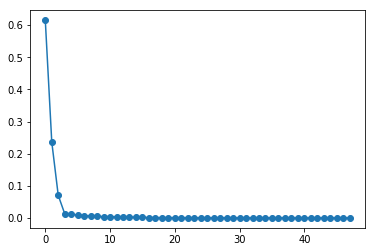

In [61]:
plt.plot(pca_full.explained_variance_ratio_, '-o')

In [62]:
print(pca_full.components_[:,0:4])

[[ -2.63313687e-02  -1.19782077e-02  -1.90296093e-02  -4.39050806e-03]
 [  2.99803508e-03   5.42704065e-04   5.90602651e-04  -2.82930695e-04]
 [  4.76986872e-01   2.53594501e-01   3.69332159e-01   9.64691174e-02]
 [  3.43600642e-02   9.00168387e-03   1.92042337e-03   9.74919925e-03]
 [ -8.21507168e-02  -3.35920583e-02  -5.13598505e-02  -3.50411012e-02]
 [  4.82710479e-03  -1.45485544e-02  -5.98030541e-03  -3.29554003e-04]
 [ -1.51010494e-02  -1.09933910e-03  -1.58533763e-02  -1.74462072e-03]
 [  1.03316755e-02   4.42743473e-03   1.05025743e-03  -2.31012016e-05]
 [  3.89296799e-02   9.61944601e-03  -9.73630345e-02  -1.47623440e-02]
 [ -8.08865925e-02  -3.27186305e-03   3.89218146e-02   1.85575445e-03]
 [ -1.57521128e-01  -9.44154804e-02  -2.39402651e-01  -4.31253074e-02]
 [  7.94776757e-01  -9.21626489e-02  -2.78682601e-01  -5.22722765e-02]
 [  3.11435770e-02   2.64896050e-02  -2.52909373e-03   1.27238829e-02]
 [ -1.02377183e-01   1.60109321e-01  -1.54774851e-03   1.06209872e-02]
 [ -6.

(3063, 48)


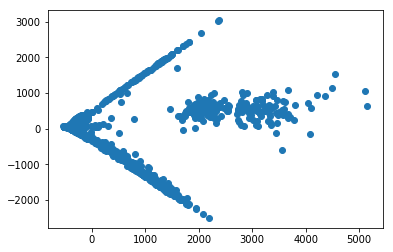

In [63]:
transformed_df = pca_full.transform(df_for_pca)
plt.plot(transformed_df[:,0], transformed_df[:,1], 'o')
print(transformed_df.shape)

# Demo

In [119]:
demo_files = [x for x in os.listdir("demo_data") if x.endswith('.csv')]
demo_data = pd.concat((pd.read_csv("demo_data/" + f, header = None) for f in demo_files), ignore_index = True)
demo_data.columns = ['el1', 'el2', 'el3', 'el4', 'quality1', 'quality2', 'quality3', 'quality4' ,'name', 'imageID', 'imageSTEP']
demo_data.head()

,el1,el2,el3,el4,quality1,quality2,quality3,quality4,name,imageID,imageSTEP
0,886.644,773.140,830.715,883.354,2,1,1,2,kate2906usa978307200.0,0,1
1,834.005,776.430,830.715,778.075,2,1,1,2,kate2906usa978307200.0,0,1
2,886.644,771.495,830.715,778.075,2,1,1,2,kate2906usa978307200.0,0,1
3,728.726,758.335,829.070,857.034,2,1,1,2,kate2906usa978307200.0,0,1
4,886.644,764.915,835.650,883.354,2,1,1,2,kate2906usa978307200.0,0,1


In [120]:
fix_data_mistake(demo_data)

Best features test

In [104]:
demo_set, demo_target = feature_extraction_with_wavelets(demo_data,'bior3.3')
demo_train_set, demo_train_target = mix_dataset(demo_set, demo_target)

demo_train_set_transformed = pca_full.transform(demo_train_set)

demo_clf = RandomForestClassifier(n_estimators = 150)
demo_clf = demo_clf.fit(demo_train_set_transformed[:,0:20], demo_train_target)

start load dataset
total time with bior3.3 is 0.0-0


In [105]:
demo_train_set_transformed[0:5,0:6]

array([[-446.23311069,   61.8845992 ,  403.73008724,  -88.03736979,
         280.54249609,  -20.19366953],
       [-331.76044908,  -28.95081598,  207.43455364,  -91.81104802,
         291.77625496,   -9.99484709],
       [-441.05103451,   38.75750656, -106.19639996,  -11.15216756,
          65.37582984,   -6.36456184],
       [-272.79894741,   36.43407896,  -27.03710984,  -64.7174367 ,
          80.46849109,   -8.25439923],
       [-342.41573454,  -36.12454397,   59.28954459,  -39.13593723,
         167.13816973,    0.81164029]])

In [106]:
test_files = [x for x in os.listdir("demo_data/test") if x.endswith('.csv')]
print(test_files)

['kate2978307200_0TEST.csv', 'katedemousa28_06978307200_0TEST.csv', 'stas29_06usa978307200_0TEST.csv', 'stasdemo2978307200_0TEST.csv']


In [107]:
for f in test_files:
    print("Current file: {}".format(f))
    demo_data_test = pd.read_csv("demo_data/test/" + f, header = None)
    demo_data_test.columns = ['el1', 'el2', 'el3', 'el4', 'quality1', 'quality2', 'quality3', 'quality4' ,'name', 'imageID', 'imageSTEP']
    fix_data_mistake(demo_data_test)
    demo_test_set, demo_test_target = feature_extraction_with_wavelets(demo_data_test, 'bior3.3')
    demo_test_set_transformed = pca_full.transform(demo_test_set)
    pred = demo_clf.predict(demo_test_set_transformed[:,0:20])
    print("\nClasses: {}".format(demo_clf.classes_))
    print("\nProbabilities: \n{}\n".format(demo_clf.predict_proba(demo_test_set_transformed[:,0:20])))
    print("Decisions: \n{}\n".format(pred))

Current file: kate2978307200_0TEST.csv
start load dataset
total time with bior3.3 is 0.0-0

Classes: ['kate2906usa978307200.0' 'nikita978307200.0' 'oleja978307200.0'
 'olesia978307200.0' 'stas26.06demousa978307200.0']

Probabilities: 
[[ 0.58        0.01333333  0.02        0.28666667  0.1       ]
 [ 0.25333333  0.01333333  0.03333333  0.28        0.42      ]
 [ 0.8         0.          0.          0.14666667  0.05333333]]

Decisions: 
['kate2906usa978307200.0' 'stas26.06demousa978307200.0'
 'kate2906usa978307200.0']

Current file: katedemousa28_06978307200_0TEST.csv
start load dataset
total time with bior3.3 is 0.0-0

Classes: ['kate2906usa978307200.0' 'nikita978307200.0' 'oleja978307200.0'
 'olesia978307200.0' 'stas26.06demousa978307200.0']

Probabilities: 
[[ 0.03333333  0.04        0.08666667  0.51333333  0.32666667]]

Decisions: 
['olesia978307200.0']

Current file: stas29_06usa978307200_0TEST.csv
start load dataset
total time with bior3.3 is 0.0-0

Classes: ['kate2906usa978307200.0

All features test

In [121]:
demo_set, demo_target = feature_extraction_with_wavelets(demo_data,'bior3.3')
demo_train_set, demo_train_target = mix_dataset(demo_set, demo_target)
demo_clf = RandomForestClassifier(n_estimators = 150)
demo_clf = demo_clf.fit(demo_train_set, demo_train_target)

start load dataset
total time with bior3.3 is 0.016666666666666666-1


Current file: kate2978307200_0TEST.csv
start load dataset
total time with bior3.3 is 0.0-0
[[ 8.54208586  0.21697795 -0.83329552 -1.81879331]
 [ 0.21697795  1.63643535 -1.05450667 -0.49110684]
 [-0.83329552 -1.05450667  3.05259316  0.50259693]
 [-1.81879331 -0.49110684  0.50259693  1.82631172]]

Classes: ['kate2906usa978307200.0' 'nikita978307200.0' 'oleja978307200.0'
 'olesia978307200.0' 'stas26.06demousa978307200.0']

Probabilities: 
[[ 0.73333333  0.          0.          0.10666667  0.16      ]
 [ 0.74666667  0.          0.          0.08        0.17333333]
 [ 0.76        0.          0.          0.08666667  0.15333333]]

Decisions: 
['kate2906usa978307200.0' 'kate2906usa978307200.0' 'kate2906usa978307200.0']


Final Decision: 
kate2906usa978307200.0


Mahalanobis distance from class (T2 test): 
764303.656017296


P-value: 
0.0

Current file: katedemousa28_06978307200_0TEST.csv
start load dataset
total time with bior3.3 is 0.0-0
[[ 8.54208586  0.21697795 -0.83329552 -1.81879331]
 [ 0.

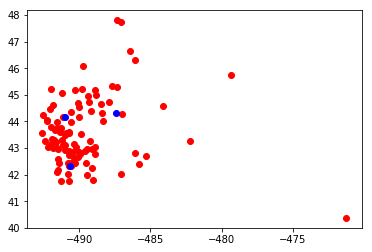

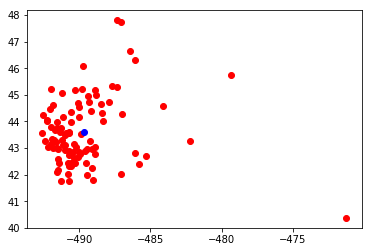

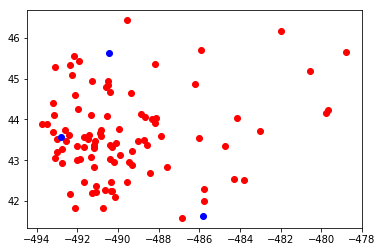

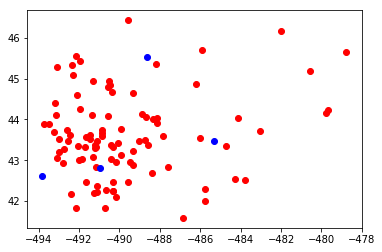

In [123]:
def centring(x, mn):
    return(x - mn)

for f in test_files:
    print("Current file: {}".format(f))
    demo_data_test = pd.read_csv("demo_data/test/" + f, header = None)
    demo_data_test.columns = ['el1', 'el2', 'el3', 'el4', 'quality1', 'quality2', 'quality3', 'quality4' ,'name', 'imageID', 'imageSTEP']
    fix_data_mistake(demo_data_test)
    demo_test_set, demo_test_target = feature_extraction_with_wavelets(demo_data_test, 'bior3.3')
    pred = demo_clf.predict(demo_test_set)
    
    cnt = Counter(pred)
    dec = cnt.most_common(1)[0][0]

    decision_rows = demo_target[demo_target['id'] == dec].index.values
    decision_matrix = demo_set.iloc[decision_rows,:]
    
    decision_matrix_transformed = pca_full.transform(preprocessing.scale(decision_matrix))
    plt.figure()
    plt.plot(decision_matrix_transformed[:,0], decision_matrix_transformed[:,1], 'ro')
    
    demo_test_set_transformed = pca_full.transform(preprocessing.scale(demo_test_set))
    plt.plot(demo_test_set_transformed[:,0], demo_test_set_transformed[:,1], 'bo')
    
    mu1 = np.mean(decision_matrix_transformed, axis = 0) #decision_matrix_transformed.apply(np.mean)
    #decision_matrix_centered = decision_matrix.apply(centring, 1, mn = mu1)
    
    data_mu = np.mean(demo_test_set_transformed, axis = 0)#demo_test_set_transformed.apply(np.mean)
    #demo_test_set_centered = demo_test_set.apply(centring, 1, mn = data_mu)
    
    #1/(decision_matrix.shape[0] - 1) * np.dot(np.transpose(decision_matrix_centered), decision_matrix_centered)
    s1 = np.cov(decision_matrix_transformed[:,0:4], rowvar = False)
    print(s1)
    #s2 = np.cov(demo_test_set_transformed[:,0:1], bias = True)
    
    t2 = np.dot(np.dot((data_mu[0:4] - mu[0:4]),np.linalg.inv(s1/demo_test_set.shape[0])),np.transpose(data_mu[0:4] - mu[0:4]))
    pval = 1 - scipy.stats.chi2.cdf(t2, s1.shape[0])
    
    print("\nClasses: {}".format(demo_clf.classes_))
    print("\nProbabilities: \n{}\n".format(demo_clf.predict_proba(demo_test_set)))
    print("Decisions: \n{}\n".format(pred))
    print("\nFinal Decision: \n{}\n".format(dec))
    print("\nMahalanobis distance from class (T2 test): \n{}\n".format(t2))
    print("\nP-value: \n{}\n".format(pval))
    
    

# What if a new person came?

Lets say we've got new date of some person, which we've never seen before.

In this experiment we will take 300 random rows from a new file (from image 11) and try to classify them.

In [124]:
new_person_data = pd.read_csv("demo_data/new_person/Varvara Nikolaeva3.06.csv", header = None)
new_person_data.columns = ['el1', 'el2', 'el3', 'el4', 'quality1', 'quality2', 'quality3', 'quality4' ,'name', 'imageID', 'imageSTEP']
fix_data_mistake(new_person_data)

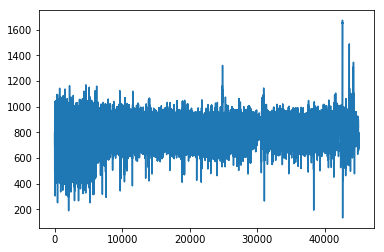

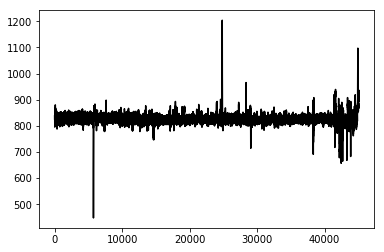

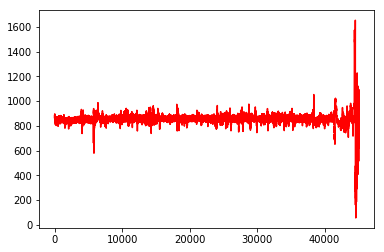

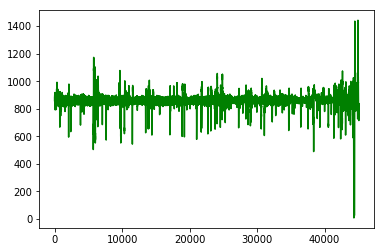

In [125]:
plt.figure()
plt.plot(new_person_data['el1'])
plt.figure()
plt.plot(new_person_data['el2'], color = 'black')
plt.figure()
plt.plot(new_person_data['el3'], color = 'red')
plt.figure()
plt.plot(new_person_data['el4'], color = 'green')

In [126]:
idx = np.random.randint(0, high = new_person_data[new_person_data['imageID'] == 10].shape[0] - window)
idx
new_person_test_part = new_person_data[new_person_data['imageID'] == 10].iloc[idx:(idx + window),:]
print(new_person_test_part.shape)

(300, 11)


In [127]:
new_person_test_set, new_person_target = feature_extraction_with_wavelets(new_person_test_part, 'bior3.3')
pred = demo_clf.predict(new_person_test_set)
print("\nClasses: {}".format(demo_clf.classes_))
print("\nProbabilities: \n{}\n".format(demo_clf.predict_proba(new_person_test_set)))
print("Decisions: \n{}\n".format(pred))

start load dataset
total time with bior3.3 is 0.0-0

Classes: ['kate2906usa978307200.0' 'nikita978307200.0' 'oleja978307200.0'
 'olesia978307200.0' 'stas26.06demousa978307200.0']

Probabilities: 
[[ 0.06666667  0.01333333  0.12666667  0.52        0.27333333]]

Decisions: 
['olesia978307200.0']



In [128]:
decision_rows = demo_target[demo_target['id'] == pred[0]].index.values
decision_matrix = demo_set.iloc[decision_rows,:]
print(decision_matrix)

          max11       max12       max13       max14       max21       max22  \
287  142.824355  106.689622  105.798961   49.435073  114.410593   65.676461   
288  199.151093  130.824532  124.972863   51.470656   46.144474   66.131001   
289  255.877763  142.993614  142.130551   58.449800   49.072153   59.222155   
290  204.185335  137.291387  101.802375   37.803166   75.470828   62.869806   
291  105.319034   95.985012  106.435320   33.441201   46.980399   58.109063   
292  114.985907  135.813042   72.153781   26.752855   51.946640   60.522402   
293  116.503463  127.777702  153.541785   42.746549   80.456659   72.849426   
294  128.411279  150.548901  148.607234   56.413686   68.842921   30.400843   
295   90.509626  114.942166  116.394785   39.256978   68.873814   49.485075   
296   90.338326  135.011737   99.559813   80.550423   36.781655   33.338765   
297  164.874962   66.829230   91.392582   25.299043   37.650474   51.439220   
298  153.811467  136.014137   92.826164   27.916222 

Let's try to check the decision made with Hotteling's T2 test.

0.0


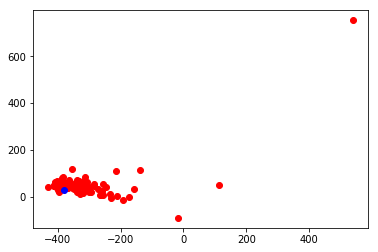

In [130]:
decision_matrix_transformed = pca_full.transform(decision_matrix)
plt.figure()
plt.plot(decision_matrix_transformed[:,0], decision_matrix_transformed[:,1], 'ro')
    
new_person_test_set_transformed = pca_full.transform(new_person_test_set)
plt.plot(new_person_test_set_transformed[:,0], new_person_test_set_transformed[:,1], 'bo')
    
mu1 = np.mean(decision_matrix_transformed, axis = 0)
data_mu = np.mean(new_person_test_set_transformed, axis = 0)

s1 = np.cov(decision_matrix_transformed[:,0:10], rowvar = False)
t2 = np.dot(np.dot((data_mu[0:10] - mu[0:10]),np.linalg.inv(s1/new_person_test_set_transformed.shape[0])),np.transpose(data_mu[0:10] - mu[0:10]))
pval = 1 - scipy.stats.chi2.cdf(t2, s1.shape[0])
print(pval)

In [91]:
def centring(x, mn):
    return(x - mn)

mu = decision_matrix.apply(np.mean)
decision_matrix_centered = decision_matrix.apply(centring, 1, mn = mu)
s = 1/(decision_matrix.shape[0] - 1) * np.dot(np.transpose(decision_matrix_centered), decision_matrix_centered)

t2 = np.dot(np.dot((new_person_test_set - mu),np.linalg.inv(s)),np.transpose(new_person_test_set - mu))
print(t2)
1 - scipy.stats.chi2.cdf(t2, decision_matrix.shape[1])

[[ 2588.43115624]]


array([[ 0.]])

# Experiments

In [134]:
#Перебор по одному образу
def one_image_run_all(wavelet):
    for image_num in range(images_count):
        print("Image {}".format(image_num))
        train_set, train_target = feature_extraction_with_wavelets(initial_df, wavelet, True, images_range = range(image_num, image_num + 1))
        test_set, test_target = feature_extraction_with_wavelets(initial_df,wavelet, False, images_range = range(image_num, image_num + 1))
    
        train_set, train_target = mix_dataset(train_set, train_target)
        test_set, test_target = mix_dataset(test_set, test_target)
        clf = RandomForestClassifier(n_estimators = 96)
        clf = clf.fit(train_set, train_target)
        pred = clf.predict(test_set)
        count = 0.0
        for i in range(len(pred)):
            if pred[i] == test_target[i]:
                count = count + 1
            
        print("wavelet {} acc {}".format(wavelet, count/len(pred))) 

In [135]:
#Перебор каждого образа для каждого вейвлета
#for name in names:
one_image_run_all('dmey')

Image 0
start load dataset
total time with dmey is 0.06666666666666667-4
start load dataset
total time with dmey is 0.06666666666666667-4
wavelet dmey acc 0.7575757575757576
Image 1
start load dataset
total time with dmey is 0.06666666666666667-4
start load dataset
total time with dmey is 0.06666666666666667-4
wavelet dmey acc 0.5454545454545454
Image 2
start load dataset
total time with dmey is 0.06666666666666667-4
start load dataset
total time with dmey is 0.06666666666666667-4
wavelet dmey acc 0.6666666666666666
Image 3
start load dataset
total time with dmey is 0.06666666666666667-4
start load dataset
total time with dmey is 0.06666666666666667-4
wavelet dmey acc 0.6666666666666666
Image 4
start load dataset
total time with dmey is 0.06666666666666667-4
start load dataset
total time with dmey is 0.06666666666666667-4
wavelet dmey acc 0.6666666666666666
Image 5
start load dataset
total time with dmey is 0.06666666666666667-4
start load dataset
total time with dmey is 0.066666666666

In [138]:
#Перебираем разное количество 
def parts_of_data_run_all(wavelet):
    for image_num in range(images_count):
        print("\nNumber of images: {}".format(image_num + 1))
        train_set, train_target = feature_extraction_with_wavelets(initial_df, wavelet, True, images_range = range(image_num + 1))
        test_set, test_target = feature_extraction_with_wavelets(initial_df, wavelet, False, images_range = range(image_num + 1))
    
        train_set, train_target = mix_dataset(train_set, train_target)
        test_set, test_target = mix_dataset(test_set, test_target)
        clf = RandomForestClassifier(n_estimators = 96)
        clf = clf.fit(train_set, train_target)
        pred = clf.predict(test_set)
        count = 0.0
        for i in range(len(pred)):
            if pred[i] == test_target[i]:
                count = count + 1
            
        print("wavelet {} acc {}".format(wavelet, count/len(pred))) 

In [139]:
#Только один тип dwt иначе работает очень-очень долго
parts_of_data_run_all('dmey')


Number of images: 1
start load dataset
total time with dmey is 0.06666666666666667-4
start load dataset
total time with dmey is 0.06666666666666667-4
wavelet dmey acc 0.696969696969697

Number of images: 2
start load dataset
total time with dmey is 0.06666666666666667-4
start load dataset
total time with dmey is 0.06666666666666667-4
wavelet dmey acc 0.6212121212121212

Number of images: 3
start load dataset
total time with dmey is 0.06666666666666667-4
start load dataset
total time with dmey is 0.06666666666666667-4
wavelet dmey acc 0.7070707070707071

Number of images: 4
start load dataset
total time with dmey is 0.06666666666666667-4
start load dataset
total time with dmey is 0.06666666666666667-4
wavelet dmey acc 0.6666666666666666

Number of images: 5
start load dataset
total time with dmey is 0.06666666666666667-4
start load dataset
total time with dmey is 0.06666666666666667-4
wavelet dmey acc 0.7575757575757576

Number of images: 6
start load dataset
total time with dmey is 0.

In [76]:
#Посмотрим на bior3.3, так как с ним получились хорошие результаты выше
parts_of_data_run_all('bior3.3')

Number of images: 1
start load dataset
total time with bior3.3 is 0.25-15
start load dataset
total time with bior3.3 is 0.25-15
wavelet bior3.3 acc 0.65625
Number of images: 2
start load dataset
total time with bior3.3 is 0.26666666666666666-16
start load dataset
total time with bior3.3 is 0.25-15
wavelet bior3.3 acc 0.7052631578947368
Number of images: 3
start load dataset
total time with bior3.3 is 0.26666666666666666-16
start load dataset
total time with bior3.3 is 0.25-15
wavelet bior3.3 acc 0.7734375
Number of images: 4
start load dataset
total time with bior3.3 is 0.25-15
start load dataset
total time with bior3.3 is 0.25-15
wavelet bior3.3 acc 0.743455497382199
Number of images: 5
start load dataset
total time with bior3.3 is 0.23333333333333334-14
start load dataset
total time with bior3.3 is 0.23333333333333334-14
wavelet bior3.3 acc 0.7890295358649789
Number of images: 6
start load dataset
total time with bior3.3 is 0.26666666666666666-16
start load dataset
total time with bi

In [140]:
#Что получится, если есть только пять человек
for name in names:
    test(name, number_of_people = 5)

start load dataset
total time with haar is 0.016666666666666666-1
start load dataset
total time with haar is 0.0-0
wavelet haar acc 0.8607594936708861
start load dataset
total time with dmey is 0.016666666666666666-1
start load dataset
total time with dmey is 0.0-0
wavelet dmey acc 0.9113924050632911
start load dataset
total time with bior1.1 is 0.016666666666666666-1
start load dataset
total time with bior1.1 is 0.0-0
wavelet bior1.1 acc 0.8734177215189873
start load dataset
total time with bior2.2 is 0.016666666666666666-1
start load dataset
total time with bior2.2 is 0.0-0
wavelet bior2.2 acc 0.9113924050632911
start load dataset
total time with bior3.3 is 0.016666666666666666-1
start load dataset
total time with bior3.3 is 0.016666666666666666-1
wavelet bior3.3 acc 0.9240506329113924
start load dataset
total time with bior4.4 is 0.016666666666666666-1
start load dataset
total time with bior4.4 is 0.016666666666666666-1
wavelet bior4.4 acc 0.8987341772151899
start load dataset
total

In [143]:
#Эксперимент с пятью людьми и 10 образами
#Обучаем на одних образах, тестируем на других
def five_people_test(wavelet):
    train_set, train_target = feature_extraction_with_wavelets(initial_df, wavelet, True, number_of_people = 5, images_range = range(5))
    test_set, test_target = feature_extraction_with_wavelets(initial_df, wavelet, False, number_of_people = 5, images_range = range(5,10))
    
    train_set, train_target = mix_dataset(train_set, train_target)
    test_set, test_target = mix_dataset(test_set, test_target)
    clf = RandomForestClassifier(n_estimators = 96)
    clf = clf.fit(train_set, train_target)
    pred = clf.predict(test_set)
    count = 0.0
    for i in range(len(pred)):
        if pred[i] == test_target[i]:
            count = count + 1
            
    print("wavelet {} acc {}".format(wavelet, count/len(pred))) 

In [144]:
for name in names:
    five_people_test(name)

start load dataset
total time with haar is 0.016666666666666666-1
start load dataset
total time with haar is 0.0-0
wavelet haar acc 0.84
start load dataset
total time with dmey is 0.0-0
start load dataset
total time with dmey is 0.0-0
wavelet dmey acc 0.92
start load dataset
total time with bior1.1 is 0.0-0
start load dataset
total time with bior1.1 is 0.0-0
wavelet bior1.1 acc 0.88
start load dataset
total time with bior2.2 is 0.0-0
start load dataset
total time with bior2.2 is 0.0-0
wavelet bior2.2 acc 0.88
start load dataset
total time with bior3.3 is 0.0-0
start load dataset
total time with bior3.3 is 0.0-0
wavelet bior3.3 acc 0.96
start load dataset
total time with bior4.4 is 0.0-0
start load dataset
total time with bior4.4 is 0.0-0
wavelet bior4.4 acc 0.92
start load dataset
total time with bior5.5 is 0.0-0
start load dataset
total time with bior5.5 is 0.0-0
wavelet bior5.5 acc 0.8
start load dataset
total time with bior6.8 is 0.0-0
start load dataset
total time with bior6.8 is 0

In [146]:
#forward selection образов. Последовательно выбираем образы, которые дают наименьшую ошибку на текущем шаге
def forward_stepwise_image_selection(wavelet, bootstrap = True):
    overall_best_set = set()#set, в котором окажется наилучшая комбинация среди всех (в смысле forward selection)
    overall_best_acc = 0.0 #соответствующий success rate
    current_size_best_set = set()#текуще наилучшее множество размера i
    current_size_best_acc = 0
    steps = dict()
    full_set = set(range(16))
    for i in range(16):
        cur_best_set = current_size_best_set
        cur_best_acc = 0
        for img in full_set:
            current_acc = 0
            current_set = set(current_size_best_set)
            if img not in current_set:
                current_set.add(img)
                train_set, train_target = feature_extraction_with_wavelets(initial_df, wavelet, True, images_range = current_set)
                test_set, test_target = feature_extraction_with_wavelets(initial_df, wavelet, False, images_range = current_set)
                train_set, train_target = mix_dataset(train_set, train_target)
                test_set, test_target = mix_dataset(test_set, test_target)
                
                clf = RandomForestClassifier(n_jobs = -1, n_estimators = 96) if (bootstrap) else RandomForestClassifier(n_jobs = -1, n_estimators = 96, bootstrap = False)
                clf = clf.fit(train_set, train_target)
                sc = clf.score(test_set, test_target)
        
                if sc > cur_best_acc:
                    cur_best_acc = sc
                    cur_best_set = current_set
        current_size_best_set = cur_best_set
        current_size_best_acc = cur_best_acc
        print("Best set of size {} is: {}\nWith acc: {}\n".format(i+1, current_size_best_set, current_size_best_acc))
        steps[i] = (current_size_best_set, current_size_best_acc)
        if current_size_best_acc > overall_best_acc:
            overall_best_set = current_size_best_set
            overall_best_acc = current_size_best_acc
    print("Overall best set: {}\nAcc: {}\n".format(overall_best_set, overall_best_acc))
    return (steps)

In [147]:
forward_stepwise_image_selection('haar') #Наилучшими для haar оказались образы (0,2,7,11)

start load dataset
total time with haar is 0.06666666666666667-4
start load dataset
total time with haar is 0.06666666666666667-4
start load dataset
total time with haar is 0.06666666666666667-4
start load dataset
total time with haar is 0.06666666666666667-4
start load dataset
total time with haar is 0.06666666666666667-4
start load dataset
total time with haar is 0.06666666666666667-4
start load dataset
total time with haar is 0.06666666666666667-4
start load dataset
total time with haar is 0.08333333333333333-5
start load dataset
total time with haar is 0.06666666666666667-4
start load dataset
total time with haar is 0.06666666666666667-4
start load dataset
total time with haar is 0.06666666666666667-4
start load dataset
total time with haar is 0.06666666666666667-4
start load dataset
total time with haar is 0.06666666666666667-4
start load dataset
total time with haar is 0.06666666666666667-4
start load dataset
total time with haar is 0.06666666666666667-4
start load dataset
total 

{0: ({11}, 0.72727272727272729),
 1: ({2, 11}, 0.75757575757575757),
 2: ({2, 6, 11}, 0.77777777777777779),
 3: ({2, 4, 6, 11}, 0.79545454545454541),
 4: ({0, 2, 4, 6, 11}, 0.78787878787878785),
 5: ({0, 2, 4, 5, 6, 11}, 0.78787878787878785),
 6: ({0, 2, 4, 5, 6, 8, 11}, 0.79220779220779225),
 7: ({0, 2, 4, 5, 6, 7, 8, 11}, 0.79545454545454541),
 8: ({0, 2, 4, 5, 6, 7, 8, 9, 11}, 0.80808080808080807),
 9: ({0, 2, 4, 5, 6, 7, 8, 9, 11, 14}, 0.79393939393939394),
 10: ({0, 1, 2, 4, 5, 6, 7, 8, 9, 11, 14}, 0.79063360881542699),
 11: ({0, 1, 2, 4, 5, 6, 7, 8, 9, 11, 14, 15}, 0.79545454545454541),
 12: ({0, 1, 2, 4, 5, 6, 7, 8, 9, 11, 12, 14, 15}, 0.79254079254079257),
 13: ({0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 11, 12, 14, 15}, 0.79653679653679654),
 14: ({0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 11, 12, 13, 14, 15}, 0.79959514170040491),
 15: ({0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15},
  0.78937381404174578)}

In [112]:
#Пять человек, 4 (наилучших) образа
for name in names:
    test(name, number_of_people = 5,img_range = [0,2,7,11])

start load dataset
total time with haar is 0.03333333333333333-2
start load dataset
total time with haar is 0.03333333333333333-2
wavelet haar acc 0.95
start load dataset
total time with dmey is 0.03333333333333333-2
start load dataset
total time with dmey is 0.03333333333333333-2
wavelet dmey acc 1.0
start load dataset
total time with bior1.1 is 0.03333333333333333-2
start load dataset
total time with bior1.1 is 0.03333333333333333-2
wavelet bior1.1 acc 0.95
start load dataset
total time with bior3.3 is 0.03333333333333333-2
start load dataset
total time with bior3.3 is 0.03333333333333333-2
wavelet bior3.3 acc 1.0
start load dataset
total time with bior6.8 is 0.03333333333333333-2
start load dataset
total time with bior6.8 is 0.03333333333333333-2
wavelet bior6.8 acc 1.0
start load dataset
total time with coif1 is 0.03333333333333333-2
start load dataset
total time with coif1 is 0.03333333333333333-2
wavelet coif1 acc 0.95
start load dataset
total time with coif3 is 0.033333333333333

In [113]:
#10 человек, 4 (наилучших) образа
for name in names:
    test(name, number_of_people = 10,img_range = [0,2,7,11])

start load dataset
total time with haar is 0.06666666666666667-4
start load dataset
total time with haar is 0.06666666666666667-4
wavelet haar acc 0.725
start load dataset
total time with dmey is 0.06666666666666667-4
start load dataset
total time with dmey is 0.06666666666666667-4
wavelet dmey acc 0.775
start load dataset
total time with bior1.1 is 0.06666666666666667-4
start load dataset
total time with bior1.1 is 0.08333333333333333-5
wavelet bior1.1 acc 0.725
start load dataset
total time with bior3.3 is 0.08333333333333333-5
start load dataset
total time with bior3.3 is 0.08333333333333333-5
wavelet bior3.3 acc 0.825
start load dataset
total time with bior6.8 is 0.08333333333333333-5
start load dataset
total time with bior6.8 is 0.08333333333333333-5
wavelet bior6.8 acc 0.775
start load dataset
total time with coif1 is 0.08333333333333333-5
start load dataset
total time with coif1 is 0.1-6
wavelet coif1 acc 0.75
start load dataset
total time with coif3 is 0.08333333333333333-5
sta

In [43]:
#Далее идет код для полного перебора всех комбинаций образов.
#Для 16-ти образов число комбинаций меньше 10^5, тем не менее, работает все очень долго
def powerset(iterable):
    "powerset([1,2,3]) --> () (1,) (2,) (3,) (1,2) (1,3) (2,3) (1,2,3)"
    s = list(iterable)
    return itertools.chain.from_iterable(combinations(s, r) for r in range(len(s)+1))


In [63]:
def best_images(wavelet):
    best_accuracy = 0.0
    best_set = []
    for img_set in powerset(range(images_count)):
        if len(img_set) > 0:
            train_set, train_target = new_get_dataset(wavelet, True, images_range = img_set)
            test_set, test_target = new_get_dataset(wavelet, False, images_range = img_set)
            train_set, train_target = mix_dataset(train_set, train_target)
            test_set, test_target = mix_dataset(test_set, test_target)
            clf = RandomForestClassifier(n_estimators = 96)
            clf = clf.fit(train_set, train_target)
            pred = clf.predict(test_set)
            count = 0.0
            for i in range(len(pred)):
                if pred[i] == test_target[i]:
                    count = count + 1
                    
            if (best_accuracy < count/len(pred)):
                best_accuracy = count/len(pred)
                best_set = img_set
            print("\nCurrent image set: {}\nAccuracy: {}".format(img_set, count/len(pred)))
    print("\nBest set: {}\nAccuracy: {}".format(best_set, best_accuracy))

In [64]:
best_images('haar')

start load dataset
total time with haar is 0.26666666666666666-16
start load dataset
total time with haar is 0.26666666666666666-16

Current image set: (0,)
Accuracy: 0.71875
start load dataset
total time with haar is 0.26666666666666666-16
start load dataset
total time with haar is 0.26666666666666666-16

Current image set: (1,)
Accuracy: 0.5625
start load dataset
total time with haar is 0.26666666666666666-16
start load dataset
total time with haar is 0.26666666666666666-16

Current image set: (2,)
Accuracy: 0.625
start load dataset
total time with haar is 0.26666666666666666-16
start load dataset
total time with haar is 0.26666666666666666-16

Current image set: (3,)
Accuracy: 0.6451612903225806
start load dataset
total time with haar is 0.26666666666666666-16
start load dataset
total time with haar is 0.26666666666666666-16

Current image set: (4,)
Accuracy: 0.59375
start load dataset
total time with haar is 0.2833333333333333-17
start load dataset
total time with haar is 0.2833333

KeyboardInterrupt: 

# Gradient Boosting Classifier

In [131]:
#Эксперемент с gbrt
#def gradient_boosted_regression_trees(wavelet):
train_set, train_target = feature_extraction_with_wavelets(initial_df, 'bior3.3',full = False, is_it_training =  True)
test_set, test_target = feature_extraction_with_wavelets(initial_df, 'bior3.3', full = False,is_it_training = False)
#train_set, train_target = new_get_dataset('haar', True)
#test_set, test_target = new_get_dataset('haar', False)
train_set, train_target = mix_dataset(train_set, train_target)
test_set, test_target = mix_dataset(test_set, test_target)   

#Тип модели
estimator = GradientBoostingClassifier(n_estimators = 1000, max_depth = 3)
#Обучение
fit = estimator.fit(train_set, train_target)
#Предсказание
pred = estimator.predict(test_set)
#Доля верных предсказаний
estimator.score(test_set, test_target)

start load dataset
total time with bior3.3 is 0.15-9
start load dataset
total time with bior3.3 is 0.1-6


0.91271347248576851

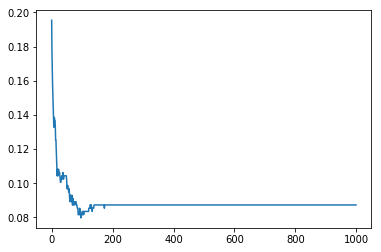

In [133]:
#Как меняется ошибка с ростом n_estimators
test_score = np.empty(len(estimator.estimators_))
for i, pred in enumerate(estimator.staged_predict(test_set)):
    count = 0.0
    for j in range(len(pred)):
                if pred[j] == test_target[j]:
                    count = count + 1
    test_score[i] = count/len(pred)

plt.plot(1 - test_score)

In [134]:
#CV
#Работает очень долго!
param_grid = {
    'learning_rate': [0.1, 0.05, 0.02, 0.01],
    'max_depth': [4, 6],
    'min_samples_leaf': [3, 5, 9, 17],
    'max_features': [1.0, 0.3, 0.1]
}
gs_cv = GridSearchCV(estimator, param_grid).fit(train_set, train_target)
gs_cv.best_params_

{'learning_rate': 0.01,
 'max_depth': 6,
 'max_features': 0.1,
 'min_samples_leaf': 17}

In [136]:
gs_cv.best_params_['learning_rate']

0.01

In [137]:
#Параметры выбраны с помощью cv
cv_estimator = GradientBoostingClassifier(learning_rate = gs_cv.best_params_['learning_rate'], n_estimators = 240,  min_samples_leaf= gs_cv.best_params_['min_samples_leaf'], max_depth = gs_cv.best_params_['max_depth'], max_features=gs_cv.best_params_['max_features'])

In [138]:
cv_fit = cv_estimator.fit(train_set, train_target)
cv_estimator.score(test_set, test_target)

0.91650853889943074

In [82]:
#learning_rate tuning
param_grid = {
    'learning_rate': [0.01,0.02,0.03,0.04,0.05,0.06,0.07,0.08, 0.09,0.1],
    'max_depth': [6],
    'min_samples_leaf': [17],
    'max_features': [0.1]
}
new_estimator = GradientBoostingClassifier(n_estimators = 2000, max_depth = 6)
gs_cv = GridSearchCV(new_estimator, param_grid).fit(train_set, train_target)
gs_cv.best_params_

{'learning_rate': 0.02,
 'max_depth': 6,
 'max_features': 0.1,
 'min_samples_leaf': 9}

In [141]:
def gbrt(wavelet):
    w = pywt.Wavelet(wavelet)
    level = pywt.dwt_max_level(window, w.dec_len)
    if (level >= 4):
        train_set, train_target = feature_extraction_with_wavelets(initial_df, wavelet,full = False, is_it_training =  True)
        test_set, test_target = feature_extraction_with_wavelets(initial_df, wavelet, full = False,is_it_training = False)
        train_set, train_target = mix_dataset(train_set, train_target)
        test_set, test_target = mix_dataset(test_set, test_target)  
    
        est = GradientBoostingClassifier(learning_rate = gs_cv.best_params_['learning_rate'], n_estimators = 240,  min_samples_leaf= gs_cv.best_params_['min_samples_leaf'], max_depth = gs_cv.best_params_['max_depth'], max_features=gs_cv.best_params_['max_features'])
        fit = est.fit(train_set, train_target)
        sc = est.score(test_set, test_target)
        print("wavelet {} acc {}".format(wavelet, sc))

In [142]:
for name in names:
    gbrt(name)
#Бустинг оказался хуже random forest (bagging)

start load dataset
total time with haar is 0.15-9
start load dataset
total time with haar is 0.1-6
wavelet haar acc 0.8918406072106262
start load dataset
total time with bior1.1 is 0.13333333333333333-8
start load dataset
total time with bior1.1 is 0.08333333333333333-5
wavelet bior1.1 acc 0.8918406072106262
start load dataset
total time with bior2.2 is 0.15-9
start load dataset
total time with bior2.2 is 0.11666666666666667-7
wavelet bior2.2 acc 0.9184060721062619
start load dataset
total time with bior3.3 is 0.15-9
start load dataset
total time with bior3.3 is 0.11666666666666667-7
wavelet bior3.3 acc 0.9184060721062619
start load dataset
total time with bior4.4 is 0.13333333333333333-8
start load dataset
total time with bior4.4 is 0.1-6
wavelet bior4.4 acc 0.9013282732447818
start load dataset
total time with bior5.5 is 0.13333333333333333-8
start load dataset
total time with bior5.5 is 0.08333333333333333-5
wavelet bior5.5 acc 0.8937381404174574
start load dataset
total time with b

In [163]:
#Feature importance
train_set, train_target = feature_extraction_with_wavelets(initial_df, 'bior3.3',full = False, is_it_training =  True)
test_set, test_target = feature_extraction_with_wavelets(initial_df, 'bior3.3', full = False,is_it_training = False)
train_set, train_target = mix_dataset(train_set, train_target)
test_set, test_target = mix_dataset(test_set, test_target)  
est = GradientBoostingClassifier(learning_rate = gs_cv.best_params_['learning_rate'], n_estimators = 240,  min_samples_leaf= gs_cv.best_params_['min_samples_leaf'], max_depth = gs_cv.best_params_['max_depth'], max_features=gs_cv.best_params_['max_features'])
fit = est.fit(train_set, train_target)
sc = est.score(test_set, test_target)

start load dataset
total time with bior3.3 is 0.15-9
start load dataset
total time with bior3.3 is 0.1-6


<Container object of 48 artists>

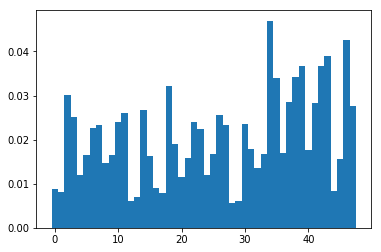

In [164]:
plt.bar(np.arange(48), est.feature_importances_, width=1)